# Simulate Irreversible Expansion

In [27]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from scipy.optimize import curve_fit
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
hppc_DIR = "../data/hppc/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_irrev_exp/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "calculate discharge energy": "true",
    }
)
# spm.print_parameter_info()
param=spm.param

In [4]:
cell = 1
sno = 7
sim_des = f'cond{sno}'
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    # ] *40,
    termination="50% capacity",
#     cccv_handling="ode",
)

25


In [5]:
drive_cycle = pd.read_csv(cyc_DIR+'peyman_drive_cycle_current'+'.csv', comment="#", header=None).to_numpy()
experiment = pybamm.Experiment(
    [
        ("Run DriveCycle (A)",
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    # ] *1,
    drive_cycles={"DriveCycle": drive_cycle},
    termination="50% capacity",
#     cccv_handling="ode",
)

In [6]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]
# Using C/5, 2C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[6]=[2.9056e-07,2.6764e-06,1.3792,1.2686e-09]
# New Mech Damage Model with Lithium plating resistane
par_val[7]=[2.190e-07,2.308e-06,1.214,2.537e-09]

In [7]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        # "Negative electrode diffusion coefficient [m2.s-1]":8.0E-15,
        # "Positive electrode diffusion coefficient [m2.s-1]":8.0E-16,
    },
    check_already_exists=False,
)


In [8]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=1)
long_sol_output =sol_long.summary_variables

In [9]:
Rn = parameter_values.evaluate(param.n.prim.R_typ)
Rp = parameter_values.evaluate(param.p.prim.R_typ)
ln = parameter_values.evaluate(param.n.L )
lp = parameter_values.evaluate(param.p.L )
kb = 30
omega_sei = 9.585e-05
omega_li = 6.94e-3/534
a_sn_0 = 3*eps_n_data/Rn
a_sp_0 = 3*eps_p_data/Rp

In [19]:
6.94e-3/534

1.299625468164794e-05

In [25]:

t = sol_long["Time [s]"].entries
del_sei_tot = sol_long["X-averaged total SEI thickness [m]"].entries
I = sol_long["Current [A]"].entries
Ah_th = sol_long["Throughput capacity [A.h]"].entries
del_sei = sol_long["X-averaged SEI thickness [m]"].entries
del_li = sol_long["X-averaged lithium plating thickness [m]"].entries
c_sei = sol_long["X-averaged SEI concentration [mol.m-3]"].entries
e_sn = sol_long["X-averaged negative electrode active material volume fraction"].entries
e_sp = sol_long["X-averaged positive electrode active material volume fraction"].entries
c_li = sol_long["X-averaged lithium plating concentration [mol.m-3]"].entries

a_sn = 3*e_sn/Rn
a_sp = 3*e_sp/Rp
del_sei_calc = (1/a_sn[0]) * c_sei * omega_sei
del_li_calc = (1/a_sn[0]) * c_li * omega_li

e_snloss = e_sn[0]-e_sn
Q = integrate.cumtrapz(abs(I),t, initial=0)/3600 #Ah


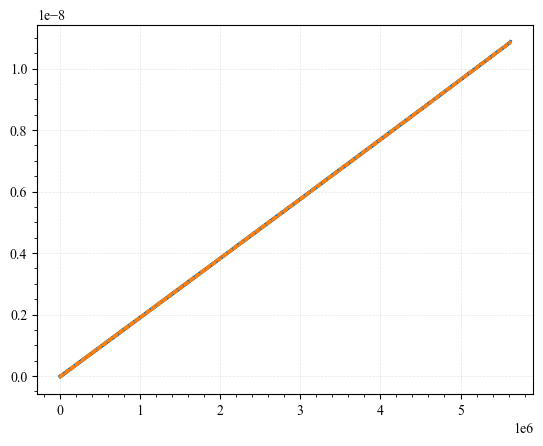

In [28]:
fig, ax = plt.subplots(1,1)
ax.plot(t,del_li)
ax.plot(t,del_li_calc,'--')

In [12]:
irrev_exp = 1e6*kb*(del_sei_calc+del_li_calc)*a_sn[0]*ln
irrev_exp_sei = 1e6*kb*(del_sei_calc)*a_sn[0]*ln
irrev_ic = 1e6*kb*3*e_snloss/Rn*Rn*ln

In [13]:
c_sei_cycle = []
c_li_cycle = []
e_sn_cycle = []
e_sp_cycle = []
e_sei_cycle = []
e_li_cycle = []

del_sei_cycle = []
del_li_cycle = []
del_in_n_cycle = []
del_in_p_cycle = []

for ii in range(len(sol_long.cycles)):
    cycle_sim = sol_long.cycles[ii]
    del_sei_c = cycle_sim["X-averaged SEI thickness [m]"].entries[0]
    del_sei_cycle.append(del_sei_c)
    c_sei_c = cycle_sim["X-averaged SEI concentration [mol.m-3]"].entries[0]
    c_sei_cycle.append(c_sei_c)
    c_li_c = cycle_sim["X-averaged lithium plating concentration [mol.m-3]"].entries[0]
    c_li_cycle.append(c_li_c)
    e_sn_c = cycle_sim["X-averaged negative electrode active material volume fraction"].entries[0]
    e_sn_cycle.append(e_sn_c)
    e_sp_c = cycle_sim["X-averaged positive electrode active material volume fraction"].entries[0]
    e_sp_cycle.append(e_sp_c)
    e_sei_cycle.append(c_sei_c*omega_sei)
    e_li_cycle.append(c_li_c*omega_li)
    del_li_cycle.append(c_li_c*omega_li*(1/a_sn_0))
e_sei_cycle = np.array(e_sei_cycle)
e_li_cycle = np.array(e_li_cycle)
del_sei_cycle = np.array(del_sei_cycle)
del_li_cycle = np.array(del_li_cycle)
e_sn_cycle = np.array(e_sn_cycle)
e_sp_cycle = np.array(e_sp_cycle)

In [14]:
e_snloss_cycle = e_sn_cycle[0]-e_sn_cycle
e_sploss_cycle = e_sp_cycle[0]-e_sp_cycle
del_in_n_cycle = e_snloss_cycle*(1/a_sn_0)
del_in_p_cycle = e_sploss_cycle*(1/a_sp_0)
del_in_n_cycle = np.array(del_in_n_cycle)
del_in_p_cycle = np.array(del_in_p_cycle)

In [15]:
e_sei_cycle_Ns = e_sei_cycle[Ns]
e_li_cycle_Ns = e_li_cycle[Ns]
e_snloss_cycle_Ns = e_snloss_cycle[Ns]
e_sploss_cycle_Ns = e_sploss_cycle[Ns]

e_sn_cycle_Ns = e_sn_cycle[Ns]
e_sp_cycle_Ns = e_sp_cycle[Ns]

del_sei_cycle_Ns = del_sei_cycle[Ns]-del_sei_cycle[0]
del_li_cycle_Ns = del_li_cycle[Ns]
del_in_n_cycle_Ns = del_in_n_cycle[Ns]
del_in_p_cycle_Ns = del_in_p_cycle[Ns]

In [16]:
df = pd.DataFrame({'N': N, 'irrev_exp': dfe['irrev_exp'],'e_sei':e_sei_cycle_Ns,
                    'e_li':e_li_cycle_Ns, 'e_in_n':e_snloss_cycle_Ns, 'e_in_p':e_sploss_cycle_Ns,
                    'e_sn':e_sn_cycle_Ns,'e_sp':e_sp_cycle_Ns,
                    'del_sei':del_sei_cycle_Ns,'del_li':del_li_cycle_Ns, 'del_in_n':del_in_n_cycle_Ns, 'del_in_p':del_in_p_cycle_Ns,
                    })
df.to_csv(res_DIR + "irrev_exp_cell"+cell_no+".csv", index=False)

In [17]:
df

,N,irrev_exp,e_sei,e_li,e_in_n,e_in_p,e_sn,e_sp,del_sei,del_li,del_in_n,del_in_p
0,0,0.0,0.000899,0.000000,0.000000,0.000000,0.599574,0.435730,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,18,23.8,0.002769,0.000097,0.002812,0.000586,0.596761,0.435144,1.039598e-08,5.416730e-10,1.563469e-08,1.569418e-09
2,57,38.3,0.006974,0.000321,0.009341,0.001934,0.590233,0.433796,3.376972e-08,1.784558e-09,5.193046e-08,5.177666e-09
3,93,54.9,0.010752,0.000527,0.015463,0.003182,0.584111,0.432549,5.477822e-08,2.932605e-09,8.596727e-08,8.518636e-09
4,134,82.8,0.014943,0.000763,0.022553,0.004607,0.577021,0.431123,7.807552e-08,4.243140e-09,1.253819e-07,1.233585e-08
5,175,95.2,0.019017,0.000999,0.029772,0.006038,0.569802,0.429692,1.007233e-07,5.555822e-09,1.655177e-07,1.616609e-08
6,216,123.2,0.022978,0.001236,0.037127,0.007473,0.562447,0.428257,1.227448e-07,6.871394e-09,2.064069e-07,2.000948e-08
7,257,153.4,0.026830,0.001473,0.044624,0.008914,0.554950,0.426816,1.441590e-07,8.191386e-09,2.480853e-07,2.386630e-08
8,298,182.9,0.030575,0.001712,0.052269,0.010359,0.547305,0.425371,1.649837e-07,9.517574e-09,2.905898e-07,2.773655e-08
9,339,250.3,0.034218,0.001952,0.060070,0.011810,0.539504,0.423920,1.852372e-07,1.085137e-08,3.339605e-07,3.162032e-08


In [18]:
sfsdfs

NameError: name 'sfsdfs' is not defined

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(Ns,e_snloss_cycle_Ns,'mx')
ax.plot(Ns,e_sploss_cycle_Ns,'bx')
ax.plot(Ns,e_sei_cycle_Ns,'rx')
ax.plot(Ns,e_li_cycle_Ns,'gx')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(dfe['Ah_th']-dfe['Ah_th'][0],dfe['N'],'kx-')
ax.plot(long_sol_output['Throughput capacity [A.h]'],long_sol_output['Cycle number'],'r--')
ax.set_xlabel("Ah Throughput")
ax.set_ylabel(r"Cycle Number")
ax.set_title(r"1.5C Aging Cell")
ax.legend(["Data","Sim"])

In [ ]:
# sim_des = 
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(dfe['Ah_th']-dfe['Ah_th'][0],dfe['Cap'],'kx-')
ax.plot(long_sol_output['Throughput capacity [A.h]'],long_sol_output['Capacity [A.h]'],'r--')
ax.set_xlabel("Ah Throughput")
ax.set_ylabel(r"Capacity [Ah]")
ax.set_title(r"1.5C Aging Cell")
ax.legend(["Data","Sim"])
# plt.savefig(fig_DIR +'cap_'+cell_no+'_Ah_2.png')

In [ ]:
# sim_des = 
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(dfe['Ah_th']-dfe['Ah_th'][0],dfe['irrev_exp'],'k')
ax.plot(Q,irrev_exp,'r--')
ax.plot(Q,irrev_exp_sei,'b--')
ax.plot(Q,irrev_exp+irrev_ic/5,'g--')
ax.set_xlabel("AH Throughput [Ah]")
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r"Irreversible Expansion 1.5C Aging Cell")
ax.legend(["Data","Model w SEI and Plating","Model w SEI"])
# plt.savefig(fig_DIR +'cycling_aging_'+cell_no+'_irrev_Exp_plating.png')

# Expansion Output

In [ ]:
cells = [4]
N_irrev_exp=[]
irrev_exp_data=[]
e_sei=[]; e_li=[]; e_in_n=[]; e_in_p=[]
del_sei=[]; del_li=[]; del_in_n=[]; del_in_p=[]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    irrev_exp = pd.read_csv(res_DIR + "irrev_exp_cell"+cell_no+".csv")
    N_irrev_exp = np.append(N_irrev_exp,irrev_exp["N"].to_numpy())
    irrev_exp_data = np.append(irrev_exp_data,irrev_exp["irrev_exp"].to_numpy())
    e_sei = np.append(e_sei,irrev_exp["e_sei"].to_numpy())
    e_li = np.append(e_li,irrev_exp["e_li"].to_numpy())
    e_in_n = np.append(e_in_n, irrev_exp["e_in_n"].to_numpy())
    e_in_p = np.append(e_in_p, irrev_exp["e_in_p"].to_numpy())
    e_sn = np.append(e_sei,irrev_exp["e_sn"].to_numpy())
    e_sp = np.append(e_li,irrev_exp["e_sp"].to_numpy())
    del_sei = np.append(del_sei,irrev_exp["del_sei"].to_numpy())
    del_li = np.append(del_li,irrev_exp["del_li"].to_numpy())
    del_in_n = np.append(del_in_n, irrev_exp["del_in_n"].to_numpy())
    del_in_p = np.append(del_in_p, irrev_exp["del_in_p"].to_numpy())

In [ ]:
b1 =0 # 0.55
b2 = 0
b3 = 0.59#0.57
b4 = 0
irrev_exp_sim = kb*1e6*(ln*(b1*e_sei+b2*e_li+b3*e_in_n)+lp*b4*e_in_p)
fig,ax= plt.subplots(1,1,figsize=(5,4))
ax.plot(N_irrev_exp,irrev_exp_data,'ko-')
ax.plot(N_irrev_exp,irrev_exp_sim,'ro-')
ax.set_xlabel("Cycle Number")
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title("Irreversible Expansion "+c_rate_c+" Cycling Aging")
ax.set_title("Irreversible Expansion Mixed"+" Cycling Aging")
ax.set_title("Irreversible Expansion "+c_rate_c+" 50% DOD Cycling Aging")
# ax.set_title("Irreversible Expansion Mixed Crate"+" 50% DOD Cycling Aging")
ax.legend(["Data","Sim"])
rmse  = pybamm.rmse(irrev_exp_data,irrev_exp_sim)
ax.text(0.7,0.1,f'RMSE: {rmse:0.1f}'+r'$\mu$m',transform=ax.transAxes) 
# fig.savefig(fig_DIR +'irrev_exp_cell_'+cell_no+'.png')

NameError: name 'kb' is not defined

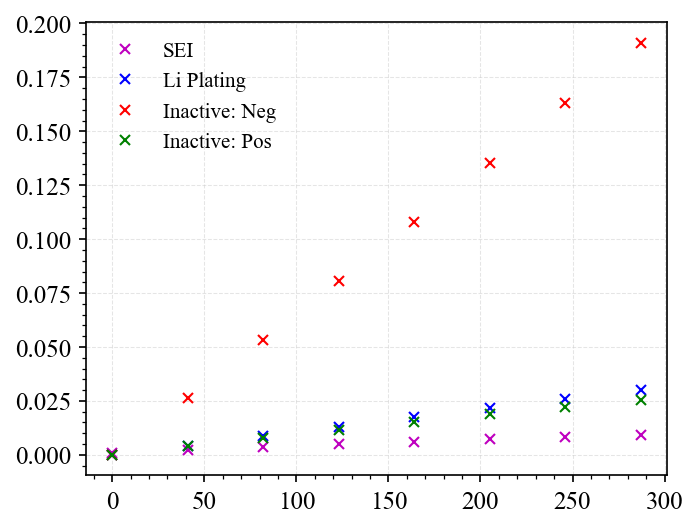

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(N_irrev_exp,e_sei,'mx')
ax.plot(N_irrev_exp,e_li,'bx')
ax.plot(N_irrev_exp,e_in_n,'rx')
ax.plot(N_irrev_exp,e_in_p,'gx')
ax.legend(["SEI","Li Plating","Inactive: Neg","Inactive: Pos"])

In [ ]:
sdfds

In [ ]:
cell = 13
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
irrev_exp = pd.read_csv(res_DIR + "irrev_exp_cell"+cell_no+".csv")
dfe_13= dfe
N_irrev_exp_13 = irrev_exp["N"]
irrev_exp_data_13 = irrev_exp["irrev_exp"]
e_sei_13 = irrev_exp["e_sei"]
e_li_13 = irrev_exp["e_li"]
e_in_n_13 = irrev_exp["e_in_n"]
e_in_p_13 = irrev_exp["e_in_p"]
e_sn_13 = irrev_exp["e_sn"]
e_sp_13 = irrev_exp["e_sp"]
del_sei_13 = irrev_exp["del_sei"]
del_li_13 = irrev_exp["del_li"]
del_in_n_13 = irrev_exp["del_in_n"]
del_in_p_13 = irrev_exp["del_in_p"]

cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
irrev_exp = pd.read_csv(res_DIR + "irrev_exp_cell"+cell_no+".csv")
dfe_1= dfe
N_irrev_exp_1 = irrev_exp["N"]
irrev_exp_data_1 = irrev_exp["irrev_exp"]
e_sei_1 = irrev_exp["e_sei"]
e_li_1 = irrev_exp["e_li"]
e_in_n_1 = irrev_exp["e_in_n"]
e_in_p_1 = irrev_exp["e_in_p"]
e_sn_1 = irrev_exp["e_sn"]
e_sp_1 = irrev_exp["e_sp"]
del_sei_1 = irrev_exp["del_sei"]
del_li_1 = irrev_exp["del_li"]
del_in_n_1 = irrev_exp["del_in_n"]
del_in_p_1 = irrev_exp["del_in_p"]

cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
irrev_exp = pd.read_csv(res_DIR + "irrev_exp_cell"+cell_no+".csv")
dfe_4= dfe
N_irrev_exp_4 = irrev_exp["N"]
irrev_exp_data_4 = irrev_exp["irrev_exp"]
e_sei_4 = irrev_exp["e_sei"]
e_li_4 = irrev_exp["e_li"]
e_in_n_4 = irrev_exp["e_in_n"]
e_in_p_4 = irrev_exp["e_in_p"]
e_sn_4 = irrev_exp["e_sn"]
e_sp_4 = irrev_exp["e_sp"]
del_sei_4 = irrev_exp["del_sei"]
del_li_4 = irrev_exp["del_li"]
del_in_n_4 = irrev_exp["del_in_n"]
del_in_p_4 = irrev_exp["del_in_p"]

cell = 7
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
dfe_7= dfe
irrev_exp = pd.read_csv(res_DIR + "irrev_exp_cell"+cell_no+".csv")
N_irrev_exp_7 = irrev_exp["N"]
irrev_exp_data_7 = irrev_exp["irrev_exp"]
e_sei_7 = irrev_exp["e_sei"]
e_li_7 = irrev_exp["e_li"]
e_in_n_7 = irrev_exp["e_in_n"]
e_in_p_7 = irrev_exp["e_in_p"]
e_sn_7 = irrev_exp["e_sn"]
e_sp_7 = irrev_exp["e_sp"]
del_sei_7 = irrev_exp["del_sei"]
del_li_7 = irrev_exp["del_li"]
del_in_n_7 = irrev_exp["del_in_n"]
del_in_p_7 = irrev_exp["del_in_p"]

cell = 10
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
dfe_10= dfe
irrev_exp = pd.read_csv(res_DIR + "irrev_exp_cell"+cell_no+".csv")
N_irrev_exp_10 = irrev_exp["N"]
irrev_exp_data_10 = irrev_exp["irrev_exp"]
e_sei_10 = irrev_exp["e_sei"]
e_li_10 = irrev_exp["e_li"]
e_in_n_10 = irrev_exp["e_in_n"]
e_in_p_10 = irrev_exp["e_in_p"]
e_sn_10 = irrev_exp["e_sn"]
e_sp_10 = irrev_exp["e_sp"]
del_sei_10 = irrev_exp["del_sei"]
del_li_10 = irrev_exp["del_li"]
del_in_n_10 = irrev_exp["del_in_n"]
del_in_p_10 = irrev_exp["del_in_p"]

cell = 16
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
dfe_16= dfe
irrev_exp = pd.read_csv(res_DIR + "irrev_exp_cell"+cell_no+".csv")
N_irrev_exp_16 = irrev_exp["N"]
irrev_exp_data_16 = irrev_exp["irrev_exp"]
e_sei_16 = irrev_exp["e_sei"]
e_li_16 = irrev_exp["e_li"]
e_in_n_16 = irrev_exp["e_in_n"]
e_in_p_16 = irrev_exp["e_in_p"]
e_sn_16 = irrev_exp["e_sn"]
e_sp_16 = irrev_exp["e_sp"]
del_sei_16 = irrev_exp["del_sei"]
del_li_16 = irrev_exp["del_li"]
del_in_n_16 = irrev_exp["del_in_n"]
del_in_p_16 = irrev_exp["del_in_p"]

cell = 19
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
dfe_19= dfe
irrev_exp = pd.read_csv(res_DIR + "irrev_exp_cell"+cell_no+".csv")
N_irrev_exp_19 = irrev_exp["N"]
irrev_exp_data_19 = irrev_exp["irrev_exp"]
e_sei_19 = irrev_exp["e_sei"]
e_li_19 = irrev_exp["e_li"]
e_in_n_19 = irrev_exp["e_in_n"]
e_in_p_19 = irrev_exp["e_in_p"]
e_sn_19 = irrev_exp["e_sn"]
e_sp_19 = irrev_exp["e_sp"]
del_sei_19 = irrev_exp["del_sei"]
del_li_19 = irrev_exp["del_li"]
del_in_n_19 = irrev_exp["del_in_n"]
del_in_p_19 = irrev_exp["del_in_p"]

In [ ]:
cells = [1,4]
N_irrev_exp=[]
irrev_exp_data=[]
e_sei=[]; e_li=[]; e_in_n=[]; e_in_p=[]
del_sei=[]; del_li=[]; del_in_n=[]; del_in_p=[]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    irrev_exp = pd.read_csv(res_DIR + "irrev_exp_cell"+cell_no+".csv")
    N_irrev_exp = np.append(N_irrev_exp,irrev_exp["N"].to_numpy())
    irrev_exp_data = np.append(irrev_exp_data,irrev_exp["irrev_exp"].to_numpy())
    e_sei = np.append(e_sei,irrev_exp["e_sei"].to_numpy())
    e_li = np.append(e_li,irrev_exp["e_li"].to_numpy())
    e_in_n = np.append(e_in_n, irrev_exp["e_in_n"].to_numpy())
    e_in_p = np.append(e_in_p, irrev_exp["e_in_p"].to_numpy())
    e_sn = np.append(e_sei,irrev_exp["e_sn"].to_numpy())
    e_sp = np.append(e_li,irrev_exp["e_sp"].to_numpy())
    del_sei = np.append(del_sei,irrev_exp["del_sei"].to_numpy())
    del_li = np.append(del_li,irrev_exp["del_li"].to_numpy())
    del_in_n = np.append(del_in_n, irrev_exp["del_in_n"].to_numpy())
    del_in_p = np.append(del_in_p, irrev_exp["del_in_p"].to_numpy())

## Curve Fitting

In [ ]:
def fitfunc(X, b1, b2, b3, b4):
  e_sei,e_li,e_in_n,e_in_p=X
  out = kb*1e6*(ln*(b1*e_sei+b2*e_li+b3*e_in_n)+lp*b4*e_in_p)
  return out

In [ ]:
ig = (1,1,0.5,0.5)
lb = 0 
lb = [-100,-100,-100,-100] 
ub = [100,100,100,100]
popt1, pcov1 = curve_fit(fitfunc, (e_sei,e_li,e_in_n,e_in_p), irrev_exp_data,p0=ig,bounds=(lb,ub))
b1_fit = round(popt1[0],2)
b2_fit = round(popt1[1],2)
b3_fit = round(popt1[2],2)
b4_fit = round(popt1[3],2)
print(f"b1 fit:{b1_fit}, b2 fit:{b2_fit}, b3 fit:{b3_fit}, b4 fit:{b4_fit}")

NameError: name 'kb' is not defined

In [ ]:
def fitfunc2(X, b1, b2, b3, b4):
  del_sei,del_li,del_in_n,del_in_p=X
  out = 1e6*(b1*del_sei+b2*del_li+b3*del_in_n+b4*del_in_p)
  return out

In [ ]:
def fitfunc3(X, b1, b2, b3, b4):
  del_sei,del_li,del_in_n,del_in_p=X
  out = 1e6*(b1*del_sei+b2*del_li+b3*del_in_n)
  out = 1e6*(b1*del_sei+b2*del_li)
  return out

In [ ]:
ig = (100,100,100,100)
lb = 0
# lb = [-100,-100,-100,-100] 
# ub = [100,100,100,100]
ub = 1e5
popt1, pcov1 = curve_fit(fitfunc3, (del_sei,del_li,del_in_n,del_in_p), irrev_exp_data,p0=ig,bounds=(lb,ub))
b1_fit = round(popt1[0],2)
b2_fit = round(popt1[1],2)
b3_fit = round(popt1[2],2)
b4_fit = round(popt1[3],2)
print(f"b1 fit:{b1_fit}, b2 fit:{b2_fit}, b3 fit:{b3_fit}, b4 fit:{b4_fit}")

b1 fit:737.58, b2 fit:1004.32, b3 fit:100.0, b4 fit:100.0


## Global Optimization

In [ ]:
from scipy.optimize import rosen, differential_evolution, Bounds

In [ ]:
def fitfunc_global(x):
  # out = kb*1e6*(ln*(x[0]*e_sei+x[1]*e_li+x[2]*e_in_n)+lp*x[3]*e_in_p)
  model = np.concatenate([
         [kb*1e6*(ln*(x[0]*e_seit+x[1]*e_lit+x[2]*e_in_nt)+lp*x[3]*e_in_pt)]
        for e_seit,e_lit,e_in_nt,e_in_pt in zip(e_sei,e_li,e_in_n,e_in_p)
    ]
  )
  error = irrev_exp_data-model
  out = np.linalg.norm(error)
  return out

In [ ]:
# bounds = Bounds([-200., -200., -200., -200.], [10., 10., 10., 10.])
bounds = Bounds([-1000., -1000., -1000., -1000.], [1000., 1000., 1000., 1000.])
result = differential_evolution(fitfunc_global, bounds,seed= 312312312)
res = result.x
print(f"b1 fit:{round(res[0],2)}, b2 fit:{round(res[1],2)}, b3 fit:{round(res[2],2)}, b4 fit:{round(res[3],2)}")

b1 fit:4.68, b2 fit:7.33, b3 fit:2.52, b4 fit:-22.57


In [ ]:
def fitfunc_global2(x):
  # out = kb*1e6*(ln*(x[0]*e_sei+x[1]*e_li+x[2]*e_in_n)+lp*x[3]*e_in_p)
  model = np.concatenate([
         [1e6*(x[0]*del_seit+x[1]*del_lit+x[2]*del_in_nt+x[3]*del_in_pt)]
        for del_seit,del_lit,del_in_nt,del_in_pt in zip(del_sei,del_li,del_in_n,del_in_p)
    ]
  )
  error = irrev_exp_data-model
  out = np.linalg.norm(error)
  return out

In [ ]:
def fitfunc_global3(x):
  # out = kb*1e6*(ln*(x[0]*e_sei+x[1]*e_li+x[2]*e_in_n)+lp*x[3]*e_in_p)
  model = np.concatenate([
         [1e6*(x[0]*del_seit+x[1]*del_lit+x[2]*del_in_nt)]
        for del_seit,del_lit,del_in_nt,del_in_pt in zip(del_sei,del_li,del_in_n,del_in_p)
    ]
  )
  error = irrev_exp_data-model
  out = np.linalg.norm(error)
  return out

In [ ]:
bounds = Bounds([-20000., -20000., -20000., -20000.], [10000., 10000., 10000., 10000.])
bounds = Bounds([0, 0, 0, 0], [10000., 10000., 10000., 10000.])
result = differential_evolution(fitfunc_global3, bounds,seed= 312312312)
res = result.x
print(f"b1 fit:{round(res[0],2)}, b2 fit:{round(res[1],2)}, b3 fit:{round(res[2],2)}, b4 fit:{round(res[3],2)}")

b1 fit:274.2, b2 fit:0.0, b3 fit:181.92, b4 fit:8516.86


In [ ]:
nn = 40
b1_grid = np.linspace(0,1,nn)
b2_grid = np.linspace(0,1,nn)
b3_grid = np.linspace(0,1,nn)
b4_grid = np.linspace(0,1,nn)

import itertools

list = [b1_grid, b2_grid, b3_grid, b4_grid]

combination = [p for p in itertools.product(*list)]
print(len(combination))

ii = 0
b1_l = []; b2_l = []; b3_l = []; b4_l = []
cost_l = []
for idx,(b1_g,b2_g,b3_g,b4_g) in enumerate(combination):
    costg = fitfunc_global([b1_g,b2_g,b3_g,b4_g])
    costg = round(costg,4)
    cost_l.append(costg)
    b1_l.append(b1_g)
    b2_l.append(b2_g)
    b3_l.append(b3_g)
    b4_l.append(b4_g)
dfg =  pd.DataFrame({"b1":b1_l,"b2":b2_l,"b3":b3_l,"b4":b4_l,"cost":cost_l})
dfs = dfg.sort_values(by=['cost'], ascending=True)
dfss = dfs[(dfs.b1>0) & (dfs.b2>0)& (dfs.b3>0) & (dfs.b4>0)]
dfss[:20]

In [ ]:
sdasdas

In [ ]:
irrev_exp_fit = [fitfunc((e_sei[j],e_li[j],e_in_n[j],e_in_p[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp))]
irrev_exp_fit_1 = [fitfunc((e_sei_1[j],e_li_1[j],e_in_n_1[j],e_in_p_1[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp_1))]
irrev_exp_fit_4 = [fitfunc((e_sei_4[j],e_li_4[j],e_in_n_4[j],e_in_p_4[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp_4))]
irrev_exp_fit_13 = [fitfunc((e_sei_13[j],e_li_13[j],e_in_n_13[j],e_in_p_13[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp_13))]

In [ ]:
irrev_exp_fit_1 = [fitfunc3((del_sei_1[j],del_li_1[j],del_in_n_1[j],del_in_p_1[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp_1))]
irrev_exp_fit_4 = [fitfunc3((del_sei_4[j],del_li_4[j],del_in_n_4[j],del_in_p_4[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp_4))]
irrev_exp_fit_13 = [fitfunc3((del_sei_13[j],del_li_13[j],del_in_n_13[j],del_in_p_13[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp_13))]

irrev_exp_fit_7 = [fitfunc3((del_sei_7[j],del_li_7[j],del_in_n_7[j],del_in_p_7[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp_7))]

irrev_exp_fit_10 = [fitfunc3((del_sei_10[j],del_li_10[j],del_in_n_10[j],del_in_p_10[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp_10))]

irrev_exp_fit_16 = [fitfunc3((del_sei_16[j],del_li_16[j],del_in_n_16[j],del_in_p_16[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp_16))]

irrev_exp_fit_19 = [fitfunc3((del_sei_19[j],del_li_19[j],del_in_n_19[j],del_in_p_19[j]), popt1[0], popt1[1], popt1[2], popt1[3]) for j in range(len(N_irrev_exp_19))]

In [ ]:
popt1[1]

1004.3191779690719

In [ ]:
del_sei_1*e_sn_1[0]/e_sn_1

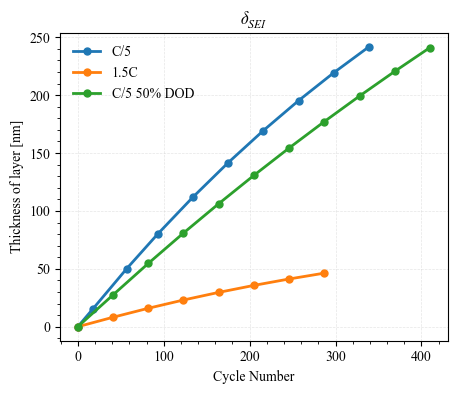

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(N_irrev_exp_1,del_sei_1*1e9,'o-')
ax1.plot(N_irrev_exp_4,del_sei_4*1e9,'o-')
ax1.plot(N_irrev_exp_13,del_sei_13*1e9,'o-')
# ax1.plot(N_irrev_exp_1,del_sei_1*e_sn_1[0]/e_sn_1,'o')
# ax1.plot(N_irrev_exp_4,del_sei_4*e_sn_4[0]/e_sn_4,'o')
# ax1.plot(N_irrev_exp_13,del_sei_13*e_sn_13[0]/e_sn_13,'o')
ax1.set_xlabel("Cycle Number")
ax1.set_ylabel(r"Thickness of layer [nm]")
ax1.legend(['C/5','1.5C','C/5 50% DOD'])
ax1.set_title(r"$\delta_{SEI}$")
plt.show()
fig.savefig(fig_DIR +'delta_sei.png')

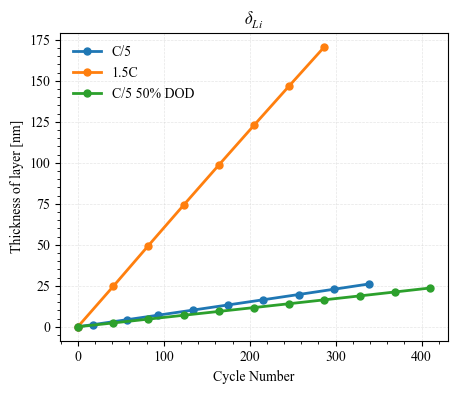

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(N_irrev_exp_1,del_li_1*1e9,'o-')
ax1.plot(N_irrev_exp_4,del_li_4*1e9,'o-')
ax1.plot(N_irrev_exp_13,del_li_13*1e9,'o-')
# ax1.plot(N_irrev_exp_1,del_li_1*e_sn_1[0]/e_sn_1,'o')
# ax1.plot(N_irrev_exp_4,del_li_4*e_sn_4[0]/e_sn_4,'o')
# ax1.plot(N_irrev_exp_13,del_li_13*e_sn_13[0]/e_sn_13,'o')
ax1.set_xlabel("Cycle Number")
ax1.set_ylabel(r"Thickness of layer [nm]")
ax1.legend(['C/5','1.5C','C/5 50% DOD'])
ax1.set_title(r"$\delta_{Li}$")
plt.show()
fig.savefig(fig_DIR +'delta_li_plating.png')

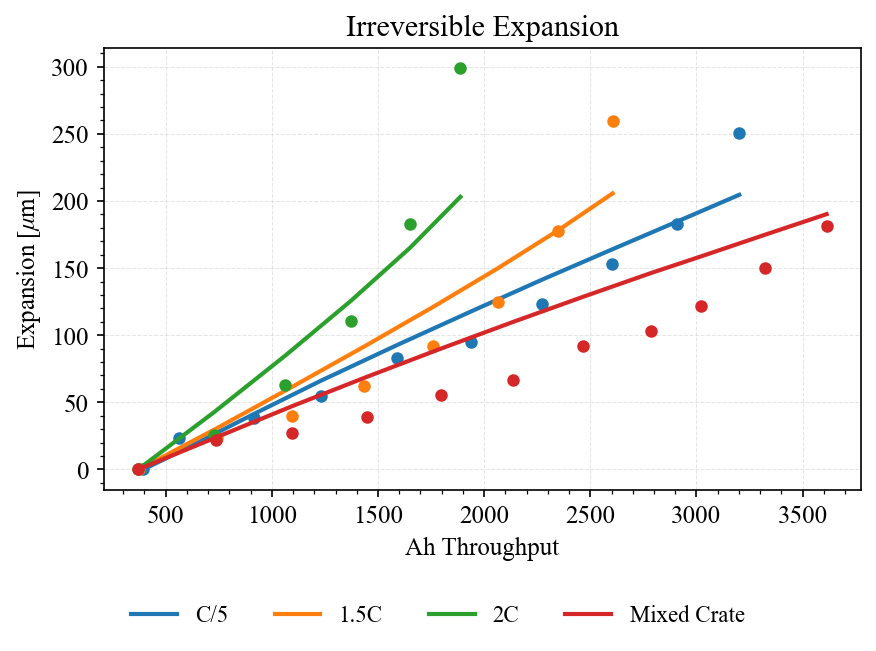

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
ax1.plot(dfe_1["Ah_th"],irrev_exp_data_1,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_1["Ah_th"],irrev_exp_fit_1,color=colors[i])
i+=1
ax1.plot(dfe_4["Ah_th"],irrev_exp_data_4,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_4["Ah_th"],irrev_exp_fit_4,color=colors[i])
i+=1
ax1.plot(dfe_7["Ah_th"],irrev_exp_data_7,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_7["Ah_th"],irrev_exp_fit_7,color=colors[i])
i+=1
ax1.plot(dfe_10["Ah_th"],irrev_exp_data_10,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_10["Ah_th"],irrev_exp_fit_10,color=colors[i])
ax1.set_xlabel('Ah Throughput')
ax1.set_ylabel(r"Expansion [$\mu$m]")
ax1.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
fig.tight_layout()
plt.savefig(fig_DIR +'cycling_aging_room_expansion_s1_1.png')

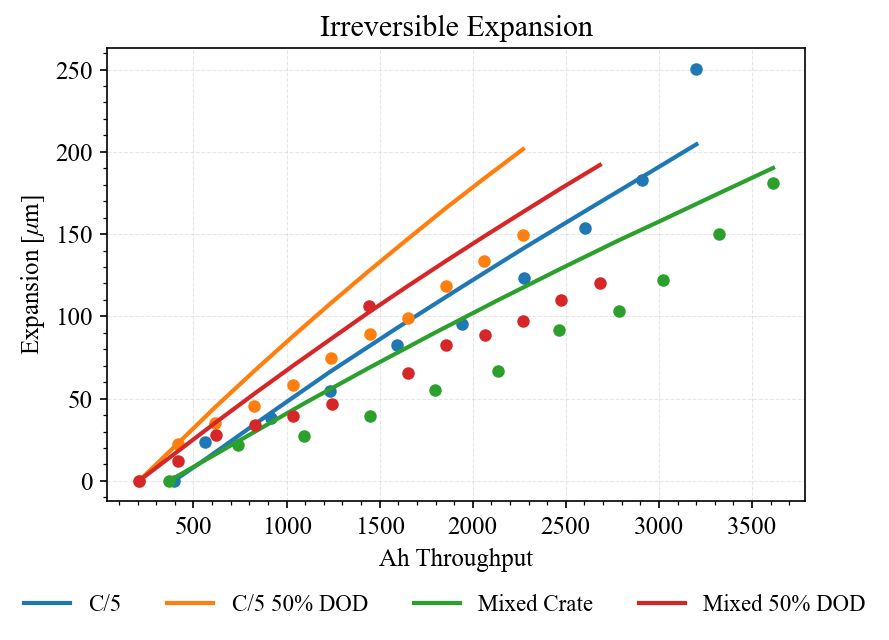

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
ax1.plot(dfe_1["Ah_th"],irrev_exp_data_1,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_1["Ah_th"],irrev_exp_fit_1,color=colors[i])
i+=1
ax1.plot(dfe_13["Ah_th"],irrev_exp_data_13,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_13["Ah_th"],irrev_exp_fit_13,color=colors[i])
i+=1
ax1.plot(dfe_10["Ah_th"],irrev_exp_data_10,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_10["Ah_th"],irrev_exp_fit_10,color=colors[i])
i+=1
ax1.plot(dfe_16["Ah_th"],irrev_exp_data_16,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_16["Ah_th"],irrev_exp_fit_16,color=colors[i])

ax1.set_xlabel('Ah Throughput')
ax1.set_ylabel(r"Expansion [$\mu$m]")
ax1.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion_s1_2.png')

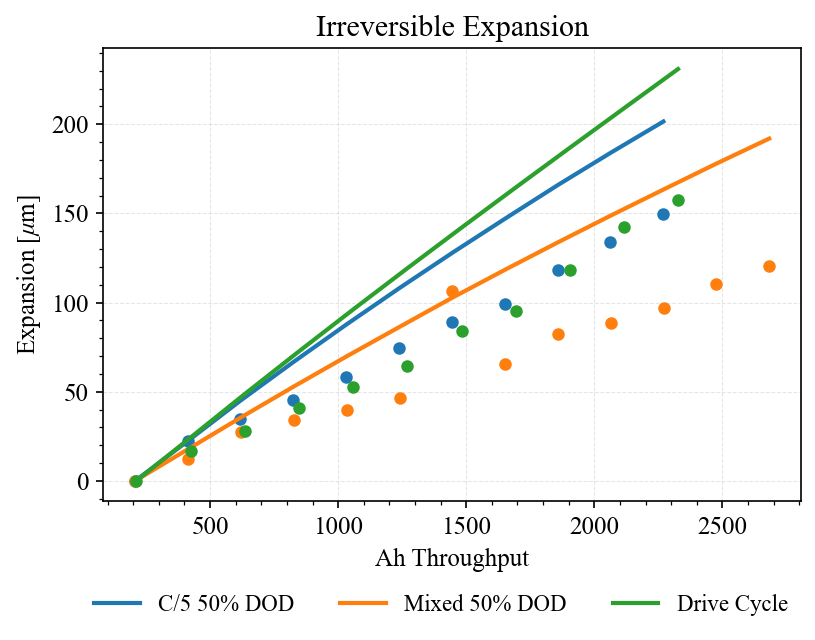

In [ ]:
cells = [1,4,7,10,13,16,19]
fig, ax1 = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
ax1.plot(dfe_13["Ah_th"],irrev_exp_data_13,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_13["Ah_th"],irrev_exp_fit_13,color=colors[i])
i+=1
ax1.plot(dfe_16["Ah_th"],irrev_exp_data_16,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_16["Ah_th"],irrev_exp_fit_16,color=colors[i])
i+=1
ax1.plot(dfe_19["Ah_th"],irrev_exp_data_19,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
ax1.plot(dfe_19["Ah_th"],irrev_exp_fit_19,color=colors[i])
ax1.set_xlabel('Ah Throughput')
ax1.set_ylabel(r"Expansion [$\mu$m]")
ax1.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=3, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion_s2_2.png')

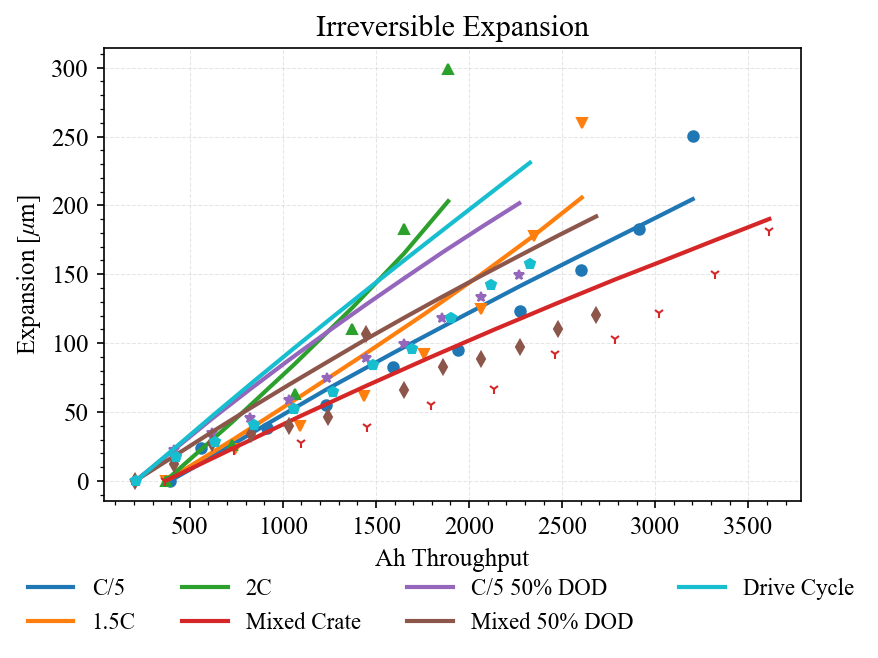

In [ ]:
cells = [1,4,7,10,13,16,19]
fig, ax1 = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
ax1.plot(dfe_1["Ah_th"],irrev_exp_data_1,linestyle="None",marker=markers[i],label='_nolegend_',color=colors[i])
ax1.plot(dfe_1["Ah_th"],irrev_exp_fit_1,color=colors[i])
i+=1
ax1.plot(dfe_4["Ah_th"],irrev_exp_data_4,linestyle="None",marker=markers[i],label='_nolegend_',color=colors[i])
ax1.plot(dfe_4["Ah_th"],irrev_exp_fit_4,color=colors[i])
i+=1
ax1.plot(dfe_7["Ah_th"],irrev_exp_data_7,linestyle="None",marker=markers[i],label='_nolegend_',color=colors[i])
ax1.plot(dfe_7["Ah_th"],irrev_exp_fit_7,color=colors[i])
i+=1
ax1.plot(dfe_10["Ah_th"],irrev_exp_data_10,linestyle="None",marker=markers[i],label='_nolegend_',color=colors[i])
ax1.plot(dfe_10["Ah_th"],irrev_exp_fit_10,color=colors[i])
i+=1
ax1.plot(dfe_13["Ah_th"],irrev_exp_data_13,linestyle="None",marker=markers[i],label='_nolegend_',color=colors[i])
ax1.plot(dfe_13["Ah_th"],irrev_exp_fit_13,color=colors[i])
i+=1
ax1.plot(dfe_16["Ah_th"],irrev_exp_data_16,linestyle="None",marker=markers[i],label='_nolegend_',color=colors[i])
ax1.plot(dfe_16["Ah_th"],irrev_exp_fit_16,color=colors[i])
i+=1
ax1.plot(dfe_19["Ah_th"],irrev_exp_data_19,linestyle="None",marker=markers[i],label='_nolegend_',color=colors[i])
ax1.plot(dfe_19["Ah_th"],irrev_exp_fit_19,color=colors[i])
ax1.set_xlabel('Ah Throughput')
ax1.set_ylabel(r"Expansion [$\mu$m]")
ax1.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion.png')

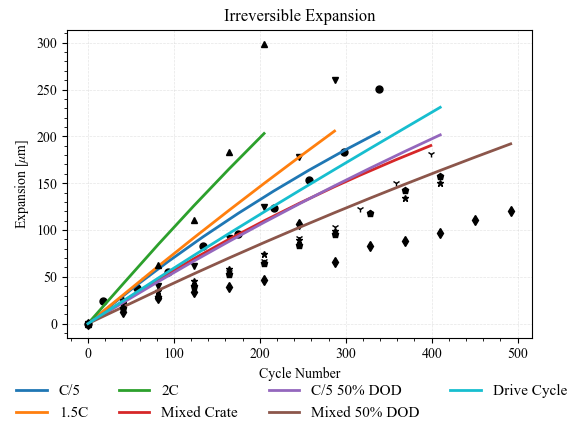

In [ ]:
cells = [1,4,7,10,13,16,19]
fig, ax1 = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
ax1.plot(N_irrev_exp_1,irrev_exp_data_1,'k',linestyle="None",marker=markers[i],label='_nolegend_')
ax1.plot(N_irrev_exp_1,irrev_exp_fit_1,color=colors[i])
i+=1
ax1.plot(N_irrev_exp_4,irrev_exp_data_4,'k',linestyle="None",marker=markers[i],label='_nolegend_')
ax1.plot(N_irrev_exp_4,irrev_exp_fit_4,color=colors[i])
i+=1
ax1.plot(N_irrev_exp_7,irrev_exp_data_7,'k',linestyle="None",marker=markers[i],label='_nolegend_')
ax1.plot(N_irrev_exp_7,irrev_exp_fit_7,color=colors[i])
i+=1
ax1.plot(N_irrev_exp_10,irrev_exp_data_10,'k',linestyle="None",marker=markers[i],label='_nolegend_')
ax1.plot(N_irrev_exp_10,irrev_exp_fit_10,color=colors[i])
i+=1
ax1.plot(N_irrev_exp_13,irrev_exp_data_13,'k',linestyle="None",marker=markers[i],label='_nolegend_')
ax1.plot(N_irrev_exp_13,irrev_exp_fit_13,color=colors[i])
i+=1
ax1.plot(N_irrev_exp_16,irrev_exp_data_16,'k',linestyle="None",marker=markers[i],label='_nolegend_')
ax1.plot(N_irrev_exp_16,irrev_exp_fit_16,color=colors[i])
i+=1
ax1.plot(N_irrev_exp_19,irrev_exp_data_19,'k',linestyle="None",marker=markers[i],label='_nolegend_')
ax1.plot(N_irrev_exp_19,irrev_exp_fit_19,color=colors[i])
ax1.set_xlabel('Cycle Number')
ax1.set_ylabel(r"Expansion [$\mu$m]")
ax1.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion_N.png')

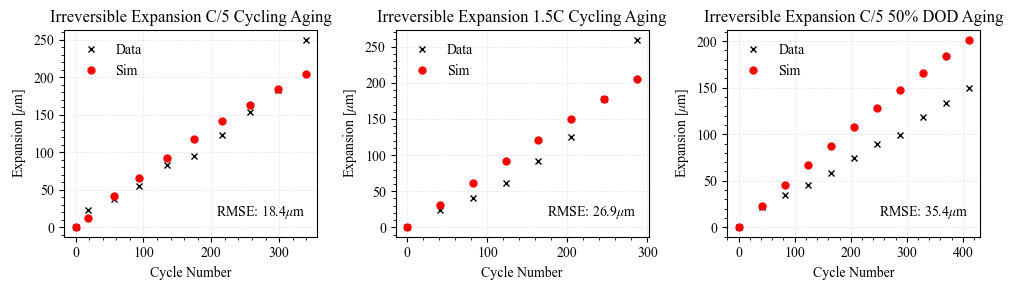

In [ ]:
fig,ax= plt.subplots(1,3,figsize=(10,3))
ax1 = ax.flat[0]
ax1.plot(N_irrev_exp_1,irrev_exp_data_1,'kx')
ax1.plot(N_irrev_exp_1,irrev_exp_fit_1,'ro')
ax1.set_xlabel("Cycle Number")
ax1.set_ylabel(r"Expansion [$\mu$m]")
ax1.set_title("Irreversible Expansion C/5 Cycling Aging")
ax1.legend(["Data","Sim"])
rmse_1  = pybamm.rmse(irrev_exp_data_1,irrev_exp_fit_1)
ax1.text(0.6,0.1,f'RMSE: {rmse_1:0.1f}'+r'$\mu$m',transform=ax1.transAxes)
ax2 = ax.flat[1]
ax2.plot(N_irrev_exp_4,irrev_exp_data_4,'kx')
ax2.plot(N_irrev_exp_4,irrev_exp_fit_4,'ro')
ax2.set_xlabel("Cycle Number")
ax2.set_ylabel(r"Expansion [$\mu$m]")
ax2.set_title("Irreversible Expansion 1.5C Cycling Aging")
ax2.legend(["Data","Sim"])
rmse_4  = pybamm.rmse(irrev_exp_data_4,irrev_exp_fit_4)
ax2.text(0.6,0.1,f'RMSE: {rmse_4:0.1f}'+r'$\mu$m',transform=ax2.transAxes)
ax3 = ax.flat[2]
ax3.plot(N_irrev_exp_13,irrev_exp_data_13,'kx')
ax3.plot(N_irrev_exp_13,irrev_exp_fit_13,'ro')
ax3.set_xlabel("Cycle Number")
ax3.set_ylabel(r"Expansion [$\mu$m]")
ax3.set_title("Irreversible Expansion C/5 50% DOD Aging")
ax3.legend(["Data","Sim"])
rmse_13  = pybamm.rmse(irrev_exp_data_13,irrev_exp_fit_13)
ax3.text(0.6,0.1,f'RMSE: {rmse_13:0.1f}'+r'$\mu$m',transform=ax3.transAxes)
fig.tight_layout()
plt.show()
fig.savefig(fig_DIR +'irrev_exp_summary.png')

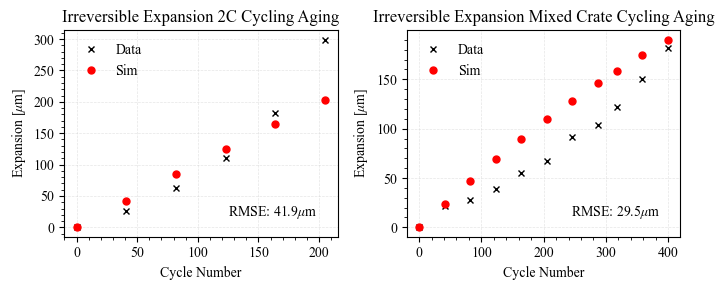

In [ ]:
fig,ax= plt.subplots(1,2,figsize=(7,3))
ax1 = ax.flat[0]
ax1.plot(N_irrev_exp_7,irrev_exp_data_7,'kx')
ax1.plot(N_irrev_exp_7,irrev_exp_fit_7,'ro')
ax1.set_xlabel("Cycle Number")
ax1.set_ylabel(r"Expansion [$\mu$m]")
ax1.set_title("Irreversible Expansion 2C Cycling Aging")
ax1.legend(["Data","Sim"])
rmse_7  = pybamm.rmse(irrev_exp_data_7,irrev_exp_fit_7)
ax1.text(0.6,0.1,f'RMSE: {rmse_7:0.1f}'+r'$\mu$m',transform=ax1.transAxes)
ax2 = ax.flat[1]
ax2.plot(N_irrev_exp_10,irrev_exp_data_10,'kx')
ax2.plot(N_irrev_exp_10,irrev_exp_fit_10,'ro')
ax2.set_xlabel("Cycle Number")
ax2.set_ylabel(r"Expansion [$\mu$m]")
ax2.set_title("Irreversible Expansion Mixed Crate Cycling Aging")
ax2.legend(["Data","Sim"])
rmse_10  = pybamm.rmse(irrev_exp_data_10,irrev_exp_fit_10)
ax2.text(0.6,0.1,f'RMSE: {rmse_10:0.1f}'+r'$\mu$m',transform=ax2.transAxes)
fig.tight_layout()
plt.show()
fig.savefig(fig_DIR +'irrev_exp_summary_2.png')